<a href="https://colab.research.google.com/github/eisbetterthanpi/pytorch/blob/main/miniproj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##miniproj

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!unzip /content/drive/MyDrive/frame/trainnorm.zip -d /train
!unzip /content/drive/MyDrive/frame/trainweap.zip -d /train

!unzip /content/drive/MyDrive/frame/testnorm.zip -d /test
!unzip /content/drive/MyDrive/frame/testweap.zip -d /test

In [ ]:
# 'https://drive.google.com/file/d/1-9AGfp6yJEpxWFFNlHoO4zEQmay_IiVQ/view?usp=sharing'
# 'https://drive.google.com/file/d/1-D0y52EAHNCMUd57UIrDkWI1ah64YFyI/view?usp=sharing'
# 'https://drive.google.com/file/d/1lXuUbBigytTraot3hlYQ4oqT8-JPmdRZ/view?usp=sharing'
# 'https://drive.google.com/file/d/1q1qIgz81KfWGFFkGuWkzGYH_zz8IPMun/view?usp=sharing'

!pip install --upgrade --no-cache-dir gdown

!gdown 1-9AGfp6yJEpxWFFNlHoO4zEQmay_IiVQ -O testnorm.zip
!gdown 1-D0y52EAHNCMUd57UIrDkWI1ah64YFyI -O testweap.zip
!gdown 1lXuUbBigytTraot3hlYQ4oqT8-JPmdRZ -O trainnorm.zip
!gdown 1q1qIgz81KfWGFFkGuWkzGYH_zz8IPMun -O trainweap.zip

!unzip /content/trainnorm.zip -d /train
!unzip /content/trainweap.zip -d /train
!unzip /content/testnorm.zip -d /test
!unzip /content/testweap.zip -d /test


###fast

In [ ]:
# @title data
import torch
import torch.nn as nn
# import torch.nn.functional as F
import torchvision
# import torchvision.transforms as transforms
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
# https://github.com/python-engineer/pytorchTutorial/blob/master/14_cnn.py

# dataset has PILImage images of range [0, 1], transform them to Tensors of normalized range [-1, 1]
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((224,224)), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# transform = transforms.Compose(transforms.ToTensor())

train_dir='/train/content/'
test_dir='/test/content/'

# train_data = datasets.ImageFolder(train_dir, transform=transform)
# test_data = datasets.ImageFolder(test_dir, transform=transform)

# batch_size = 64 # 4

# # train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
# # test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)
# train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
# test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

# def imshow(img):
#     img = img / 2 + 0.5  # unnormalize
#     npimg = img.numpy()
#     plt.imshow(np.transpose(npimg, (1, 2, 0)))
#     plt.show()

# dataiter = iter(train_loader) # get some random training images
# images, labels = next(dataiter)
# # imshow(torchvision.utils.make_grid(images))

In [ ]:
# @title pretrained
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import datasets, models, transforms
# https://pytorch.org/vision/0.12/models.html#id10
model = models.resnet152(pretrained=True) # 18 34 50 101 152
num_ftrs = model.fc.in_features
# model.fc = nn.Linear(num_ftrs, 2)
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 2),
    nn.Softmax(),
    )

c=0
for param in model.parameters():
    # print(c, param.shape)
    if c>=461: #101(312) 152(466)
        param.requires_grad = True
    else:
        param.requires_grad = False
    c+=1

# for param in model.parameters():
#     print(param.requires_grad,param.shape)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
# print(model)

In [ ]:
X = torch.rand(64, 3, 32, 32, device=device)
logits = model(X)
print(logits.shape)
# print(logits[0])
# print(logits[0].argmax(1))
pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)
# print(f"Predicted class: {y_pred}")


torch.Size([64, 2])


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [ ]:
# @title train test function

scaler = torch.cuda.amp.GradScaler()
# for data, label in data_iter:
#    optimizer.zero_grad()
#    # Casts operations to mixed precision
#    with torch.cuda.amp.autocast():
#       loss = model(data)
#    scaler.scale(loss).backward()
#    scaler.step(optimizer)
#    scaler.update()

# def strain(dataloader, model, loss_fn, optimizer):
def strain(dataloader, model, loss_fn, optimizer, scheduler=None, verbose=True):
    size = len(dataloader.dataset)
    model.train()
    lr_list, loss_list = [], []
    for batch, (x, y) in enumerate(dataloader):
        sx, sy = x.to(device), y.to(device)
        optimizer.zero_grad()
        
        with torch.cuda.amp.autocast():
            pred = model(sx)
            loss = loss_fn(pred, sy)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        if scheduler is not None:
            scheduler.step()

        # lr_list.append(optimizer.param_groups[0]["lr"])
        loss_list.append(loss.item())
        # loss.backward()
        # optimizer.step()
        if (batch) % (size//(10* len(x))) == 0:
            loss, current = loss.item(), batch * len(x)
            if verbose: print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    return lr_list, loss_list

# def train(dataloader, model, loss_fn, optimizer):
def train(dataloader, model, loss_fn, optimizer, scheduler=None, verbose=True):
    size = len(dataloader.dataset)
    model.train()
    lr_list, loss_list = [], []
    for batch, (x, y) in enumerate(dataloader):
    # for batch, ((x,y), labels) in enumerate(dataloader):
        sx, sy = x.to(device), y.to(device)
        # print("sx sy",sx.shape,sy.shape)
        pred = model(sx)
        loss = loss_fn(pred, sy)
        # loss = model.loss(sx,sy)
        optimizer.zero_grad() # reset gradients of model parameters, to prevent double-counting
        loss.backward() # Backpropagate gradients
        optimizer.step() # adjust the parameters by the gradients
        if scheduler is not None: scheduler.step()
        if (batch) % (size//(10* len(x))) == 0:
            loss, current = loss.item(), batch * len(x)
            loss_list.append(loss)
            if verbose: print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

# def test(dataloader, model, loss_fn):
def test(dataloader, model, loss_fn, verbose=True):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            x, y = X.to(device), y.to(device)
            pred = model(x)
            loss = loss_fn(pred, y)
            # predicted, actual = classes[pred[0].argmax(0)], classes[y]
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    # if verbose: print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    if verbose: print(f"Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}")
    return correct

In [ ]:
#  time epoch
import time
start = time.time()

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
strain(train_loader, model, loss_fn, optimizer, verbose=False)

end = time.time()
print("time: ",end - start)


In [ ]:
# @title wwwwwwwww
import time
start = time.time()
lr_lst, loss_lst=[],[]
loss_fn = nn.CrossEntropyLoss()

# model = ResNet(Bottleneck, [3,3,3], num_classes=10, num_channels=3).to(device)
batch_size = 64 #64 # 4 512

train_data = datasets.ImageFolder(train_dir, transform=transform)
test_data = datasets.ImageFolder(test_dir, transform=transform)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
num_batches=int(np.ceil(len(train_data)/batch_size))
train_data=0;test_data=0

base_lr, max_lr = 1e-5, 1e-3 # 1e-5, 1e-3 #0.5#
# base_lr, max_lr = 3e-6, 3e-4
end_lr, start_lr = 1e-5, 1e-3 # 0.0001,0.1

# print(num_batches)
epochs = 5 #5 20
# (1e-5/1e-1)=gamma**(num_batches*epochs)
# gamma = np.exp(np.log(1e-3/1e-1)/epochs) # for scheduler step every epoch
gamma = np.exp(np.log(end_lr/start_lr)/(num_batches*epochs)) # for scheduler step every optimizer step
# print(gamma)
# optimizer = torch.optim.SGD(model.parameters(), lr = start_lr, momentum=0.9)
optimizer = torch.optim.AdamW(model.parameters(), lr=base_lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=3e-6)

div_factor = max_lr/base_lr
# div_factor = 25
# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=max_lr, total_steps=num_iter, pct_start=0.45, anneal_strategy='cos', cycle_momentum=True, base_momentum=0.85, max_momentum=0.95, div_factor=div_factor, final_div_factor=10000.0, three_phase=True,)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=max_lr, epochs=epochs, steps_per_epoch=num_batches, pct_start=0.45, anneal_strategy='cos', cycle_momentum=True, base_momentum=0.85, max_momentum=0.95, div_factor=div_factor, final_div_factor=10000.0, three_phase=True,)
# optimizer = torch.optim.AdamW(model.parameters(), lr=start_lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=3e-6)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma) # 0.75(20)-0.9(100)
total_steps=num_batches*epochs


for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    lr=optimizer.param_groups[0]["lr"]
    # lr_lst.append(lr)
    print(lr)
    # train(train_loader, model, loss_fn, optimizer)
    lr_ls, loss_ls = strain(train_loader, model, loss_fn, optimizer, scheduler)
    # strain(train_loader, model, loss_fn, optimizer, scheduler)
    test(test_loader, model, loss_fn)
    # scheduler.step()
    # lr_lst.append(lr_ls)
    loss_lst.extend(loss_ls)
print("Done!")

end = time.time()
print("time: ",end - start)

torch.save(model.state_dict(), "model.pth")

# model = NeuralNetwork().to(device)
# model.load_state_dict(torch.load("model.pth"))

Epoch 1
-------------------------------
1.0000000000000026e-05
loss: 0.723900  [    0/ 8329]
loss: 0.689597  [  832/ 8329]
loss: 0.659986  [ 1664/ 8329]
loss: 0.611909  [ 2496/ 8329]
loss: 0.611952  [ 3328/ 8329]
loss: 0.527183  [ 4160/ 8329]
loss: 0.628553  [ 4992/ 8329]
loss: 0.518227  [ 5824/ 8329]
loss: 0.514955  [ 6656/ 8329]
loss: 0.460759  [ 7488/ 8329]
Accuracy: 79.5%, Avg loss: 0.516755
Epoch 2
-------------------------------
0.00036090434927230465
loss: 0.510830  [    0/ 8329]
loss: 0.546415  [  832/ 8329]
loss: 0.450792  [ 1664/ 8329]
loss: 0.461110  [ 2496/ 8329]
loss: 0.484833  [ 3328/ 8329]
loss: 0.513411  [ 4160/ 8329]
loss: 0.464084  [ 4992/ 8329]
loss: 0.470003  [ 5824/ 8329]
loss: 0.496978  [ 6656/ 8329]
loss: 0.462200  [ 7488/ 8329]
Accuracy: 80.3%, Avg loss: 0.500666
Epoch 3
-------------------------------
0.0012488898220548124
loss: 0.514642  [    0/ 8329]
loss: 0.464156  [  832/ 8329]
loss: 0.458837  [ 1664/ 8329]
loss: 0.423906  [ 2496/ 8329]
loss: 0.460225  [ 33

In [ ]:
pth='/content/drive/MyDrive/frame/res152.pth'

# torch.save(model.state_dict(), pth)
# model.load_state_dict(torch.load("model.pth"))


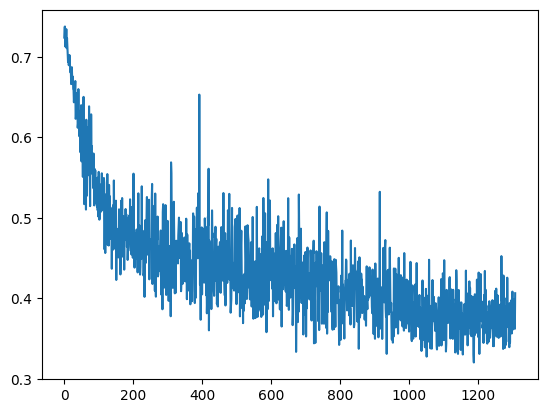

In [ ]:
import matplotlib.pyplot as plt
plt.plot(loss_lst)
# plt.plot(lr_list[:-40], loss_list[:-40])
# plt.xscale('log')
plt.show()
# plt.close()


In [ ]:
test(test_loader, model, loss_fn)

Accuracy: 80.1%, Avg loss: 0.505711


0.8008882309400445

####lr

In [ ]:
# @title pretrained
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import datasets, models, transforms
# https://pytorch.org/vision/0.12/models.html#id10
model = models.resnet152(pretrained=True) # 18 34 50 101 152
num_ftrs = model.fc.in_features
# model.fc = nn.Linear(num_ftrs, 2)
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 2),
    nn.Softmax(),
    )

c=0
for param in model.parameters():
    # print(c, param.shape)
    if c>=461: #101(312) 152(466)
        param.requires_grad = True
    else:
        param.requires_grad = False
    c+=1

model = model.to(device)


for lr in [1e-3,3e-4,1e-4,3e-5,1e-5]:
    
